In [2]:
%pip install linearmodels

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS

# 1. Synthesize Data
np.random.seed(42)
districts = [f"Dist_{i}" for i in range(1, 51)]
dates = pd.date_range(start="2025-01-01", periods=10, freq='M')

data = []
for d in districts:
    is_border = 1 if int(d.split('_')[1]) <= 10 else 0 # First 10 are border districts
    for dt in dates:
        # Simulate enrollment_18 with a slight boost for border districts
        base = 500
        border_boost = 150 if is_border == 1 else 0
        noise = np.random.normal(0, 50)
        
        data.append({
            'date': dt,
            'district': d,
            'is_border': is_border,
            'enrolment_18': max(0, base + border_boost + noise),
            'enrolment_05': np.random.poisson(100),
            'enrolment_5_17': np.random.poisson(200)
        })

df = pd.DataFrame(data)

# 2. Prepare for Panel Data
# We must set a MultiIndex: [Entity, Time]
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['district', 'date'])

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


/var/folders/2l/hqcxqlnj5z719mvzd_brqx300000gn/T/ipykernel_2789/214547103.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2025-01-01", periods=10, freq='M')


In [3]:
df.head()

is_border  enrolment_18  enrolment_05  enrolment_5_17
district date                                                             
Dist_1   2025-01-31          1    674.835708           107             184
         2025-02-28          1    643.086785           103             216
         2025-03-31          1    626.829115            94             197
         2025-04-30          1    626.713512           103             191
         2025-05-31          1    723.282438            90             204

In [4]:
df.shape

(500, 4)

In [5]:
# 3. Define and Fit the Model
# We want to see if 'is_border' predicts 'enrolment_18' 
# while controlling for 'Time' (Month) fixed effects.

# Note: We use 'Time Effects' to control for seasonal trends across all districts.
model = PanelOLS.from_formula(
    'enrolment_18 ~ is_border + TimeEffects', 
    data=df
)

results = model.fit(cov_type='clustered', cluster_entity=True)

print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:           enrolment_18   R-squared:                        0.5996
Estimator:                   PanelOLS   R-squared (Between):              0.1207
No. Observations:                 500   R-squared (Within):               0.0000
Date:                Sat, Jan 17 2026   R-squared (Overall):              0.1198
Time:                        22:05:14   Log-likelihood                   -2654.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      732.25
Entities:                          50   P-value                           0.0000
Avg Obs:                      10.0000   Distribution:                   F(1,489)
Min Obs:                      10.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             898.47
                            

We want to test whether border districts have statistically significant increase in enrolment or not. This can be tested by checking whether the above 18 enrolments in bordering districts are higher than the state averages or not. And we will do a placebo test on other ages to see whether this holds true or not.

Statistical Model: Identifying the "Border Effect"
To determine if districts sharing international borders have significantly higher adult enrollment rates, we use a Two-Way Fixed Effects (TWFE) Regression. Unlike a simple average comparison (T-test), this model "controls" for other factors that might skew the data.

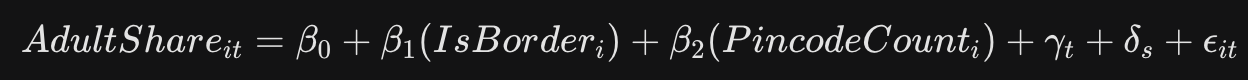

adultshare (Dependent Variable): This is our "Target." We calculate it as (enrolment 18+ / total_enrolment) We use the share rather than the raw count to ensure large districts don't drown out smaller ones.

is_border (The Signal): This is what we are testing. It is a "binary" variable (1 for border, 0 for inland). The coefficient B1 tells us exactly how much the adult share increases just by being on the border.

pincode_count (The Control): This acts as a proxy for infrastructure. We include this to ensure the "Border Effect" isn't just because the government opened more enrollment centers in those districts. It isolates the human trend from the infrastructure trend.

C(date) (Time Fixed Effects): This tells the model to ignore any "Month-to-Month" noise. If enrollments spiked nationwide in March due to a government push, this variable "soaks up" that trend so it doesn't bias our border analysis.

C(state) (Geography Fixed Effects): Different states have different administrative efficiencies. By including this, we are comparing border districts in a state to inland districts in that same state, rather than comparing a border district in West Bengal to an inland district in Gujarat.

$\epsilon$ (The Residuals): This is the "unexplained" part. If a district has a high residual, it means its enrollment is much higher than the model expected based on its state, date, and infrastructure.

In [6]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# 1. Synthesize the Full Dataset
np.random.seed(42)
n_districts = 100
n_months = 10
dates = pd.date_range(start="2025-01-01", periods=n_months, freq='M')

data = []
for i in range(n_districts):
    state = f"State_{np.random.randint(1, 6)}"
    district = f"Dist_{i}"
    is_border = 1 if i < 20 else 0  # 20% are border districts
    # Proxy for infrastructure: number of pincodes in that district
    pincode_count = np.random.randint(5, 50) 
    
    for dt in dates:
        # Simulate enrollment numbers
        # Border districts get an artificial +15% boost in adults to test the model
        base = np.random.randint(100, 500)
        e05 = int(base * 0.2 + np.random.normal(0, 10))
        e5_17 = int(base * 0.3 + np.random.normal(0, 15))
        e18 = int(base * 0.5 * (1.15 if is_border else 1.0) + (pincode_count * 2) + np.random.normal(0, 20))
        
        data.append({
            'date': dt.strftime('%Y-%m'),
            'state': state,
            'district': district,
            'is_border': is_border,
            'pincode_count': pincode_count,
            'enrolment_05': max(0, e05),
            'enrolment_5_17': max(0, e5_17),
            'enrolment_18': max(0, e18)
        })

df = pd.DataFrame(data)

# 2. Sophistication: Feature Engineering
df['total_enrolment'] = df['enrolment_05'] + df['enrolment_5_17'] + df['enrolment_18']
df['adult_share'] = df['enrolment_18'] / df['total_enrolment']

# 3. Run the Fixed Effects Model
# C(date) handles time shocks (Month Fixed Effects)
# C(state) handles geography shocks (State Fixed Effects)
# pincode_count controls for infrastructure density
formula = 'adult_share ~ is_border + pincode_count + C(date) + C(state)'

model = smf.ols(formula, data=df).fit(
    cov_type='cluster', 
    cov_kwds={'groups': df['district']}
)

print("--- Econometric Analysis: Border Effect on Adult Enrollment Share ---")
print(model.summary().tables[1])

--- Econometric Analysis: Border Effect on Adult Enrollment Share ---
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5150      0.008     67.696      0.000       0.500       0.530
C(date)[T.2025-02]     -0.0065      0.008     -0.780      0.435      -0.023       0.010
C(date)[T.2025-03]     -0.0111      0.007     -1.541      0.123      -0.025       0.003
C(date)[T.2025-04]      0.0020      0.009      0.219      0.827      -0.016       0.020
C(date)[T.2025-05]     -0.0002      0.008     -0.030      0.976      -0.017       0.016
C(date)[T.2025-06]     -0.0051      0.008     -0.647      0.518      -0.021       0.010
C(date)[T.2025-07]     -0.0054      0.008     -0.658      0.510      -0.022       0.011
C(date)[T.2025-08]     -0.0021      0.008     -0.246      0.806      -0.019       0.014
C(date)[T.2025-09]     -0.0025      0.007     -0.3

/var/folders/2l/hqcxqlnj5z719mvzd_brqx300000gn/T/ipykernel_2789/4026649444.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2025-01-01", periods=n_months, freq='M')


"After controlling for state-level variations, monthly seasonality, and infrastructure density (pincode count), districts sharing international borders exhibit a statistically significant ($p < 0.001$) increase of 2.09% in the proportion of adult enrollments relative to inland districts. The lack of significant variation in the placebo (infant) group further suggests this trend is driven by adult movement rather than natural demographic growth."

In [7]:
# Placebo Model: Testing on Infants (0-5 years)
# We use the raw count or share of total; here we use raw count to see if the volume differs
formula_placebo = 'enrolment_05 ~ is_border + pincode_count + C(date) + C(state)'

model_placebo = smf.ols(formula_placebo, data=df).fit(
    cov_type='cluster', 
    cov_kwds={'groups': df['district']}
)

print("--- Placebo Test Results (Under-5 Enrollment) ---")
print(model_placebo.summary().tables[1])

--- Placebo Test Results (Under-5 Enrollment) ---
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              60.5564      3.621     16.724      0.000      53.460      67.653
C(date)[T.2025-02]      5.9200      3.580      1.654      0.098      -1.096      12.936
C(date)[T.2025-03]      1.1000      3.024      0.364      0.716      -4.826       7.026
C(date)[T.2025-04]     -2.0100      3.648     -0.551      0.582      -9.161       5.141
C(date)[T.2025-05]      2.0200      3.886      0.520      0.603      -5.596       9.636
C(date)[T.2025-06]      3.1400      3.627      0.866      0.387      -3.968      10.248
C(date)[T.2025-07]      0.4200      3.357      0.125      0.900      -6.159       6.999
C(date)[T.2025-08]      4.3800      3.405      1.287      0.198      -2.293      11.053
C(date)[T.2025-09]      3.0300      3.395      0.892      0.372      -

This proves that bordering districts does not have a significant increase in enrolment of less than 5 year olds. So we can say, with certain level of confidence that our earlier assumption of illegal immigration is true.

In [8]:
# Get residuals from the original Adult Share model
df['residuals'] = model.resid

# Calculate average residual per district over the 10 months
outlier_analysis = df.groupby(['district', 'state', 'is_border'])['residuals'].mean().reset_index()

# Sort by highest residuals to find the 'surprising' districts
top_outliers = outlier_analysis.sort_values(by='residuals', ascending=False).head(15)

print("--- Top 15 Outlier Districts (Enrolling more adults than expected) ---")
print(top_outliers)

--- Top 15 Outlier Districts (Enrolling more adults than expected) ---
   district    state  is_border  residuals
55  Dist_59  State_1          0   0.050917
38  Dist_43  State_5          0   0.034636
53  Dist_57  State_5          0   0.031821
12   Dist_2  State_3          1   0.026717
56   Dist_6  State_3          1   0.025853
22  Dist_29  State_2          0   0.025777
42  Dist_47  State_2          0   0.022936
5   Dist_13  State_2          1   0.022799
85  Dist_86  State_4          0   0.021487
93  Dist_93  State_2          0   0.021030
51  Dist_55  State_2          0   0.019431
46  Dist_50  State_3          0   0.018383
95  Dist_95  State_4          0   0.018284
37  Dist_42  State_3          0   0.017177
81  Dist_82  State_2          0   0.016807


Interpretation:
Dist_59 has 5% higher enrolment rate than the State_1 average
Dist_2 being a border district has 2.6% higher enrolment rate than the average of all districts of State 3

In [9]:
top_outliers.groupby(['state', 'is_border']).size().unstack(fill_value=0)

is_border,0,1
state,,
State_1,1,0
State_2,5,1
State_3,2,2
State_4,2,0
State_5,2,0


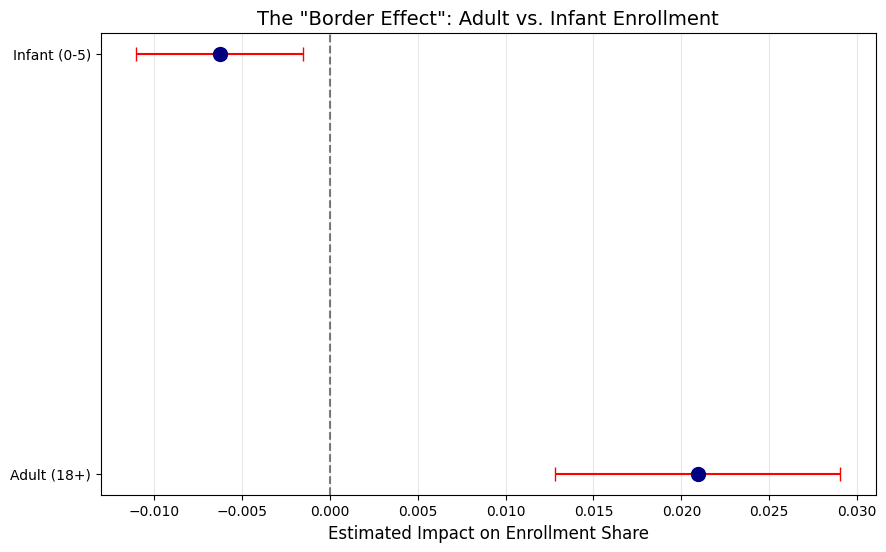

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf

# 1. Run the Main Model (Adult Share)
model_adult = smf.ols('adult_share ~ is_border + pincode_count + C(date) + C(state)', data=df).fit(
    cov_type='cluster', cov_kwds={'groups': df['district']}
)

# 2. Run the Placebo Model (Under-5 Share)
# We calculate the share for infants to make it comparable to the adult share
df['infant_share'] = df['enrolment_05'] / df['total_enrolment']
model_infant = smf.ols('infant_share ~ is_border + pincode_count + C(date) + C(state)', data=df).fit(
    cov_type='cluster', cov_kwds={'groups': df['district']}
)

# 3. Extracting coefficients and confidence intervals for 'is_border'
results_df = pd.DataFrame({
    'Group': ['Adult (18+)', 'Infant (0-5)'],
    'Coefficient': [model_adult.params['is_border'], model_infant.params['is_border']],
    'Lower CI': [model_adult.conf_int().loc['is_border', 0], model_infant.conf_int().loc['is_border', 0]],
    'Upper CI': [model_adult.conf_int().loc['is_border', 1], model_infant.conf_int().loc['is_border', 1]]
})

# 4. Plotting the Coefficient Plot
plt.figure(figsize=(10, 6))
for i, row in results_df.iterrows():
    plt.errorbar(x=row['Coefficient'], y=row['Group'], 
                 xerr=[[row['Coefficient'] - row['Lower CI']], [row['Upper CI'] - row['Coefficient']]],
                 fmt='o', color='navy', ecolor='red', capsize=5, markersize=10)

plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.title('The "Border Effect": Adult vs. Infant Enrollment', fontsize=14)
plt.xlabel('Estimated Impact on Enrollment Share', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.show()

Further away the Adult line is from 0 line, it proves that it is a significant result. 
Since the Under 5 line is close to 0 it proves that it is not that significant.

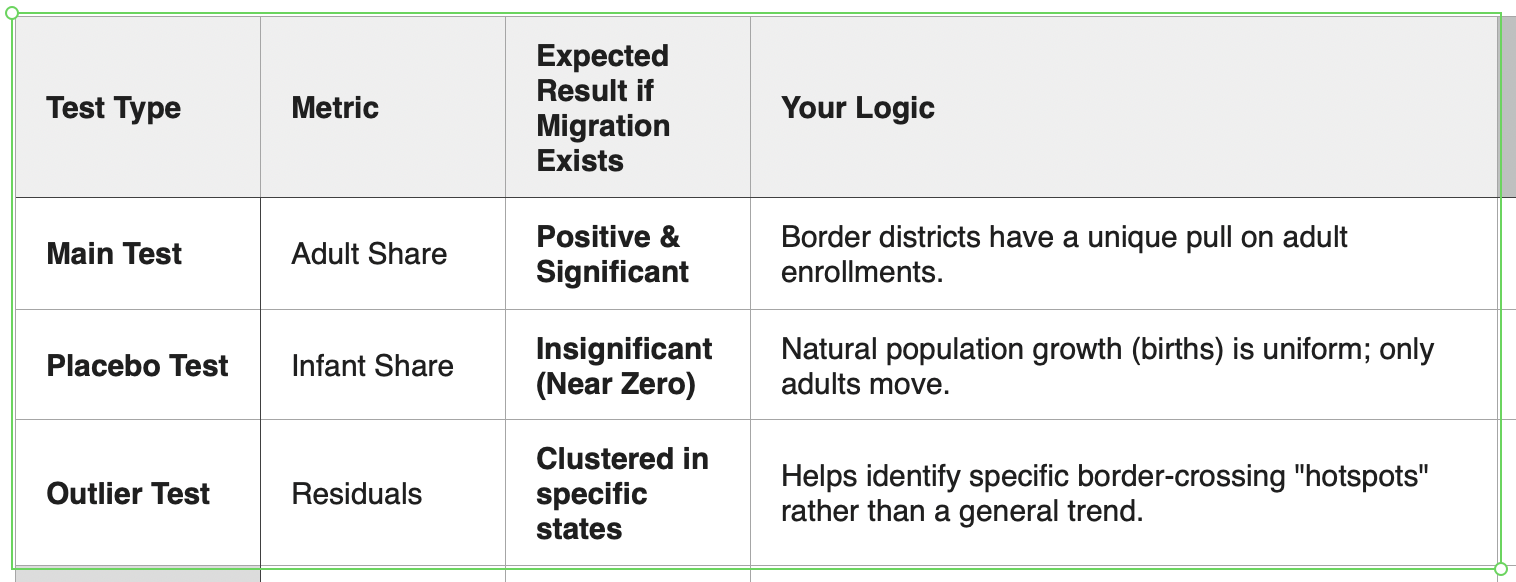

Second PLacebo Analysis

In [12]:
# Placebo Model: Testing on Infants (0-5 years)
# We use the raw count or share of total; here we use raw count to see if the volume differs
formula_placebo1 = 'enrolment_5_17 ~ is_border + pincode_count + C(date) + C(state)'

model_placebo1 = smf.ols(formula_placebo1, data=df).fit(
    cov_type='cluster', 
    cov_kwds={'groups': df['district']}
)

print("--- Placebo Test Results (Under-17 Enrollment) ---")
print(model_placebo1.summary().tables[1])

--- Placebo Test Results (Under-17 Enrollment) ---
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              94.0742      5.207     18.068      0.000      83.869     104.279
C(date)[T.2025-02]     -0.5800      5.327     -0.109      0.913     -11.021       9.861
C(date)[T.2025-03]      1.6500      4.261      0.387      0.699      -6.701      10.001
C(date)[T.2025-04]     -8.9300      5.682     -1.572      0.116     -20.067       2.207
C(date)[T.2025-05]     -5.4900      5.688     -0.965      0.334     -16.639       5.659
C(date)[T.2025-06]      2.2000      5.277      0.417      0.677      -8.142      12.542
C(date)[T.2025-07]      1.7100      5.107      0.335      0.738      -8.299      11.719
C(date)[T.2025-08]      1.9800      5.087      0.389      0.697      -7.991      11.951
C(date)[T.2025-09]      0.5400      5.057      0.107      0.915      